# Importing the Libraries and Packages need to the Projects 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import math
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

## 1-  Loading the Data  

Data Source: https://www.kaggle.com/datasets/coplin/traffic 

In [3]:
df = pd.read_csv('train27303.csv')
df.head()

,timestamp,hourly_traffic_count
0,2015-10-04 00:00:00,3
1,2015-10-04 00:05:00,16
2,2015-10-04 00:10:00,9
3,2015-10-04 00:15:00,12
4,2015-10-04 00:20:00,19


## 1.2 Data Cleansing 

In [4]:
df.set_index('timestamp', inplace=True)

In [5]:
df.index = pd.to_datetime(df.index)
df = df.resample('H').sum()

df.head()

,hourly_traffic_count
timestamp,
2015-10-04 00:00:00,137
2015-10-04 01:00:00,118
2015-10-04 02:00:00,77
2015-10-04 03:00:00,88
2015-10-04 04:00:00,124


In [6]:
df.describe()

,hourly_traffic_count
count,2208.000000
mean,305.412591
std,292.961345
min,0.000000
25%,0.000000
50%,196.000000
75%,588.000000
max,1203.000000


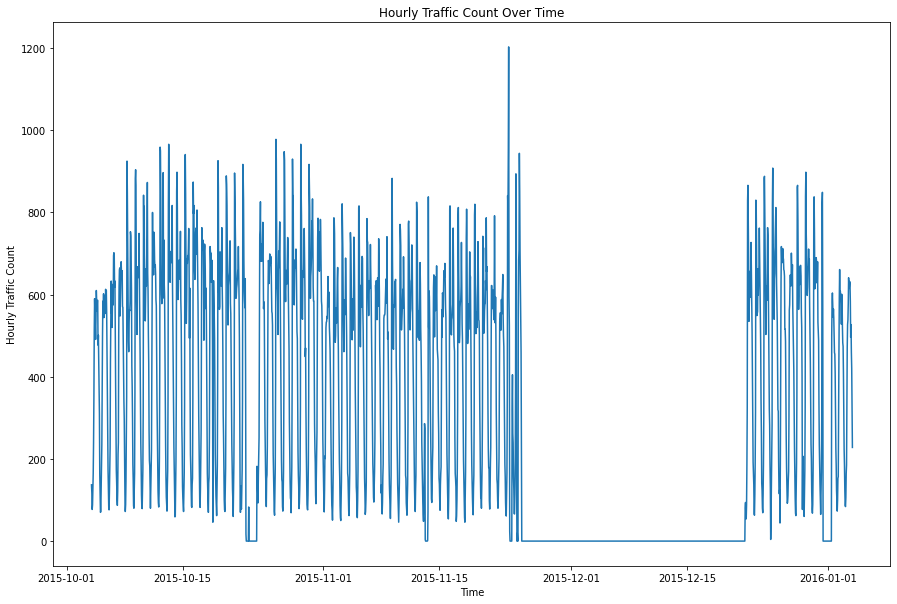

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(df.index, df['hourly_traffic_count'])

plt.xlabel('Time')
plt.ylabel('Hourly Traffic Count')
plt.title('Hourly Traffic Count Over Time')
plt.show()

In [15]:


# calculate the IQR for each column in the DataFrame
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# define the lower and upper bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# create a boolean mask for the outlier rows in the DataFrame
outlier_mask = ~df.apply(lambda x: ((x < lower_bound) | (x > upper_bound)).any(), axis=1)

# select the rows without outliers
df = df[outlier_mask]
df.size
df.describe()

,hourly_traffic_count
count,2208.000000
mean,305.412591
std,292.961345
min,0.000000
25%,0.000000
50%,196.000000
75%,588.000000
max,1203.000000


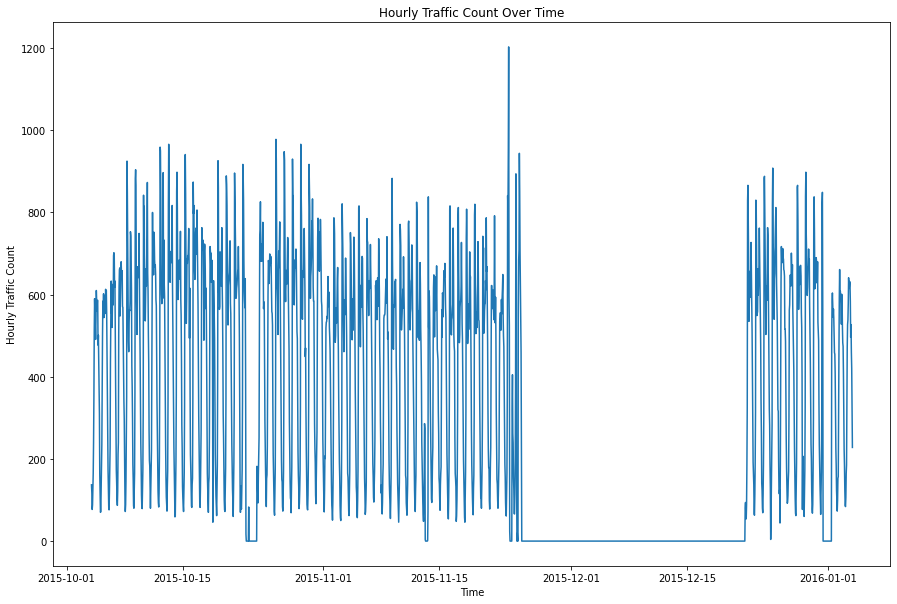

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(df.index, df['hourly_traffic_count'])

plt.xlabel('Time')
plt.ylabel('Hourly Traffic Count')
plt.title('Hourly Traffic Count Over Time')
plt.show()

## Check if the DataFrame is Stationary or not 

Many traditional models require the time series to be stationary

Stationary > Statistical properties such as mean, variance and serial correlation are constant over time.

Stationarity makes analysis more straightforward but modern approaches makes it possible to work with
data without pre-processing for stationarity.


https://stats.stackexchange.com/questions/19715/why-does-a-time-series-have-to-be-stationary

In [18]:
#Dickey-Fuller test
# df['timestamp'] = pd.to_datetime(df['timestamp'])
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['hourly_traffic_count'])

1. ADF :  -2.531460171430013
2. P-Value :  0.10800613755219829
3. Num Of Lags :  25
4. Num Of Observations Used For ADF Regression: 2182
5. Critical Values :
	 1% :  -3.4333504627066542
	 5% :  -2.8628655035890977
	 10% :  -2.567475631233297


Outlier 

In [78]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['hourly_traffic_count'],  
                            model ='additive') # here i assuume the model is 
                                                #Additivie Model that mean the time series is consis of adding 
                                                #y(t) = Level + Trend + Seasonality + Noise

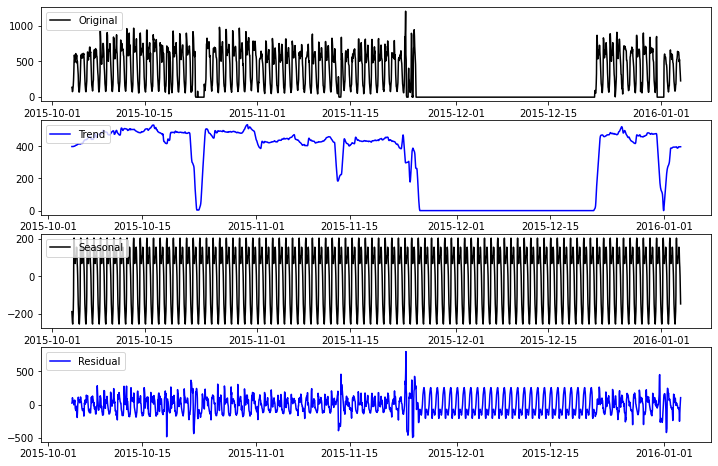

In [79]:

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid
observed = decomposed.observed
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['hourly_traffic_count'], label='Original', color='black')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='black')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='blue')
plt.legend(loc='upper left')


In [17]:
df.loc["2015-12-04 00:00:00"]

hourly_traffic_count    0
Name: 2015-12-04 00:00:00, dtype: int64

## Autocorrelation function (ACF)
The autocorrelation function is a measure of the correlation between observations of a time series that are separated by k time units (yt and yt–k).

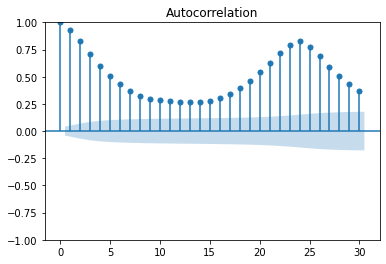

In [80]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.
from statsmodels.graphics.tsaplots import plot_acf

# Calculate the ACF
acf = plot_acf(df.hourly_traffic_count, lags=30, alpha=.05)

# Plot the ACF
plt.show()

In [81]:
df1 = df.reset_index()['hourly_traffic_count']
df1.head()

0    137
1    118
2     77
3     88
4    124
Name: hourly_traffic_count, dtype: int64

In [82]:
df1 = df1.iloc[:9792,]
df1.tail()

2203    527
2204    460
2205    420
2206    308
2207    228
Name: hourly_traffic_count, dtype: int64

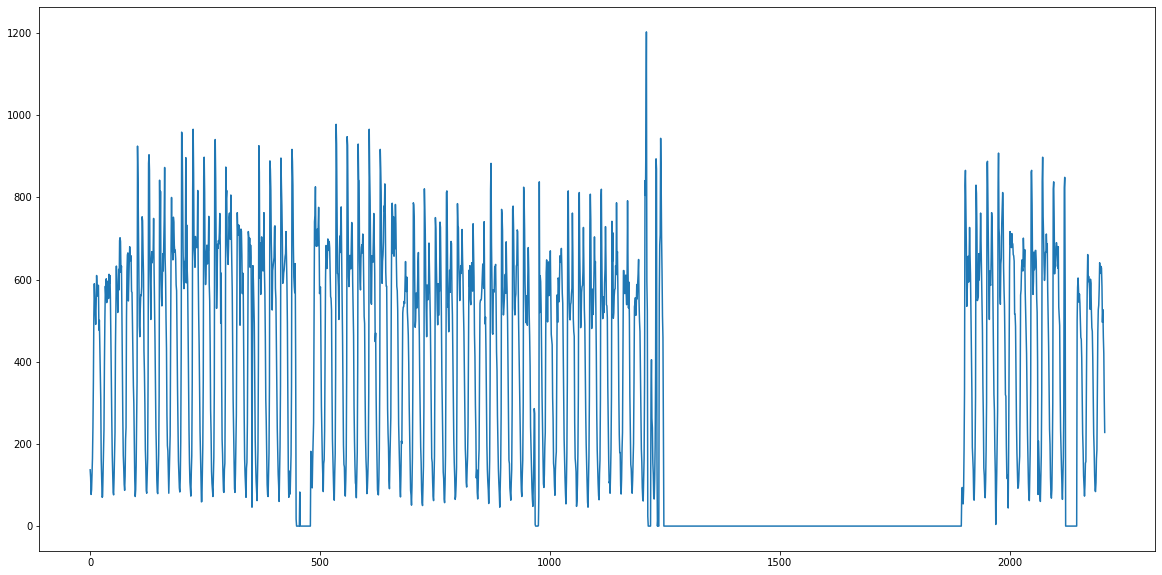

In [83]:
plt.figure(figsize=(20,10))
plt.plot(df1)
plt.show()

In [84]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [85]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [86]:
training_size = int(len(df1)*0.80)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [87]:
window = 288
X_train,y_train = create_dataset(train_data,window)
X_test, y_test = create_dataset(test_data,window)

In [88]:
model = Sequential()
model.add(Dense(40, input_dim=window, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

In [89]:
opt  = keras.optimizers.Adagrad(learning_rate = 0.05)

In [90]:
model.compile(optimizer=opt ,loss='mean_squared_error')

In [91]:
model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
148/148 [==============================] - 0s 800us/step - loss: 0.0207
Epoch 2/100
148/148 [==============================] - 0s 841us/step - loss: 0.0112
Epoch 3/100
148/148 [==============================] - 0s 808us/step - loss: 0.0091
Epoch 4/100
148/148 [==============================] - 0s 813us/step - loss: 0.0076
Epoch 5/100
148/148 [==============================] - 0s 806us/step - loss: 0.0067
Epoch 6/100
148/148 [==============================] - 0s 807us/step - loss: 0.0062
Epoch 7/100
148/148 [==============================] - 0s 805us/step - loss: 0.0058
Epoch 8/100
148/148 [==============================] - 0s 853us/step - loss: 0.0053
Epoch 9/100
148/148 [==============================] - 0s 823us/step - loss: 0.0050
Epoch 10/100
148/148 [==============================] - 0s 936us/step - loss: 0.0045
Epoch 11/100
148/148 [==============================] - 0s 876us/step - loss: 0.0045
Epoch 12/100
148/148 [==============================] - 0s 861us/step - lo

In [92]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 1ms/step


In [93]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [94]:
train_predict = train_predict.astype(int)
test_predict = test_predict.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print('RMSE-train:',math.sqrt(mean_squared_error(y_train,train_predict)))
print('MAE-train:',mean_absolute_error(y_train,train_predict))
print('R_2-train:',r2_score(y_train,train_predict))

RMSE-train: 42.03350857262391
MAE-train: 27.593094109681786
R_2-train: 0.9791996983203025


In [96]:
# print('RMSE-test:',math.sqrt(mean_squared_error(y_test,test_predict)))
# print('MAE-test:',mean_absolute_error(y_test,test_predict))
# print('R_2-train:',r2_score(y_test,test_predict))

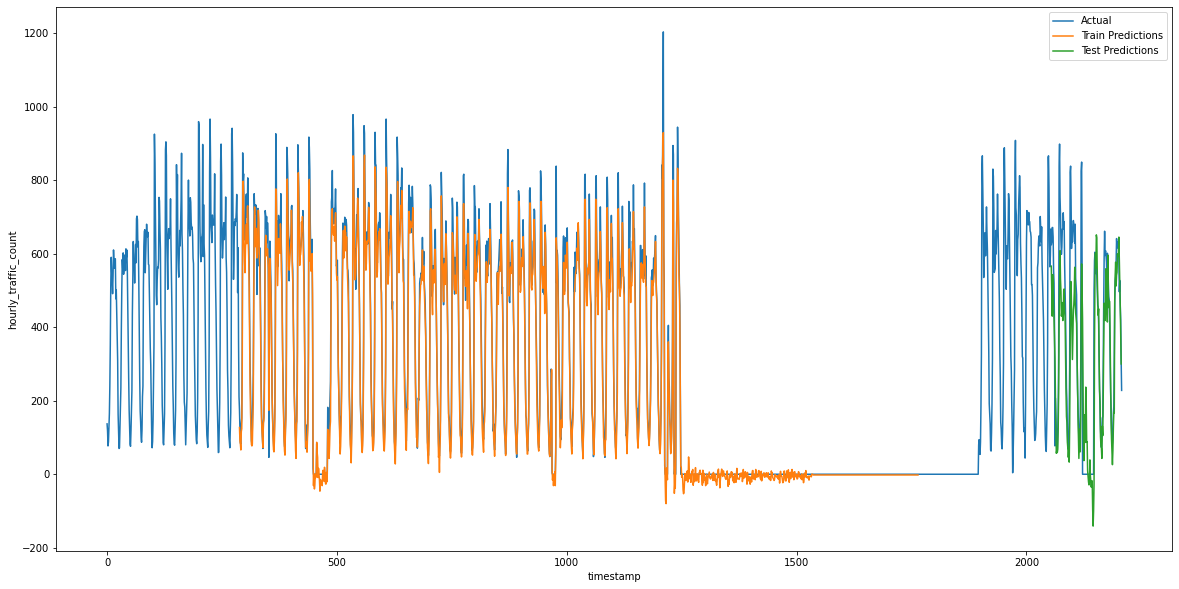

In [98]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(train_predict)+window, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(window*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df1), label='Actual')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.xlabel('timestamp')
plt.ylabel('hourly_traffic_count')
plt.legend()
plt.show()


__________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________